# AutoEncoder

In [87]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.autograd import Variable
from torchvision.utils import save_image
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# The model

In [ ]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Reading in the data and extracting the mask indexs

In [90]:
all_data_files = glob("./data/*")

In [91]:
ix_tracker = np.load(all_data_files[0]).flatten()
mask_ixs = np.argwhere(ix_tracker != -1)

In [92]:
len(mask_ixs)

66794

# Cleaning the data and reading it into train and val sets.

In [93]:
def clean_data(data):
    data[data == -1] = 0
    data[143:167, 223:247][data[143:167, 223:247] == 0] = 1
    return data 

In [94]:
X = np.array(list(map(lambda x: clean_data(np.load(x)), all_data_files)))

In [95]:
train_x, val_x = train_test_split(X)

In [97]:
num_epochs = 500 #you can go for more epochs, I am using a mac
batch_size = 16

In [98]:
def MaskLoss(base, mask):
    """
    This method generates a loss function that use only the specified indexs for calculating the loss.
    This method assumes the ixs given are from a flattened version of the images, and output. All the flattening logic for the
    inputs to the distance function are handeled here.
    """
    def distance(input, target):
         return base(
                input.flatten(start_dim=2, end_dim=3)[:,:,mask].view(input.shape[0], 1, len(mask)),
                target.flatten(start_dim=2, end_dim=3)[:,:,mask].view(target.shape[0], 1, len(mask))
            )
        
    return distance

In [99]:
model = autoencoder().cuda()
metric = nn.MSELoss()
distance = MaskLoss(metric, mask_ixs)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)#, weight_decay=1e-5)

In [100]:
train_x = torch.stack([torch.Tensor(i).view(-1, 304, 448) for i in train_x])
val_x = torch.stack([torch.Tensor(i).view(-1, 304, 448) for i in val_x])

train_dataset = TensorDataset(train_x) # create your datset
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

val_dataset= TensorDataset(val_x) # create your datset
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [76]:
model.encoder(val_x[:1].cuda()).shape

torch.Size([1, 8, 25, 37])

epoch [1/500], loss:0.0037, val_loss:0.0041
epoch [2/500], loss:0.0037, val_loss:0.0041
epoch [3/500], loss:0.0037, val_loss:0.0041
epoch [4/500], loss:0.0037, val_loss:0.0041
epoch [5/500], loss:0.0037, val_loss:0.0041
epoch [6/500], loss:0.0037, val_loss:0.0041
epoch [7/500], loss:0.0037, val_loss:0.0041
epoch [8/500], loss:0.0037, val_loss:0.0041
epoch [9/500], loss:0.0037, val_loss:0.0041
epoch [10/500], loss:0.0036, val_loss:0.0041
epoch [11/500], loss:0.0036, val_loss:0.0041
epoch [12/500], loss:0.0036, val_loss:0.0041
epoch [13/500], loss:0.0036, val_loss:0.0041
epoch [14/500], loss:0.0036, val_loss:0.0041
epoch [15/500], loss:0.0036, val_loss:0.0041
epoch [16/500], loss:0.0036, val_loss:0.0041
epoch [17/500], loss:0.0036, val_loss:0.0041
epoch [18/500], loss:0.0036, val_loss:0.0041
epoch [19/500], loss:0.0036, val_loss:0.0041
epoch [20/500], loss:0.0036, val_loss:0.0041
epoch [21/500], loss:0.0036, val_loss:0.0041
epoch [22/500], loss:0.0036, val_loss:0.0041
epoch [23/500], los

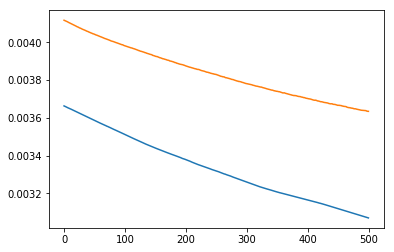

In [106]:
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    model.train()
    for data in train_dataloader:
        optimizer.zero_grad()
        img = data[0]
        img = Variable(img).cuda()
        # ===================forward=====================
        output = model(img)
        loss = distance(output, img)
        # ===================backward====================
        loss.backward()
        optimizer.step()    
    train_losses.append(loss.item())

    # Evalution
    model.eval()
    losses = []
    for val_d in val_dataloader:
        img = Variable(val_d[0]).cuda()
        out = model(img)
        loss = distance(img, out)
        losses.append(loss.item())
        
        
        
    print('epoch [{}/{}], loss:{:.4f}, val_loss:{:.4f}'.format(epoch+1, num_epochs, train_losses[-1], np.mean(losses)))
    val_losses.append(np.mean(losses))
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(val_losses)), val_losses)

In [107]:
generated = model(val_x[0].view(-1, 1, 304, 448).cuda())

In [108]:
generated[0].detach().cpu().numpy()[0,:,:].shape

(304, 448)

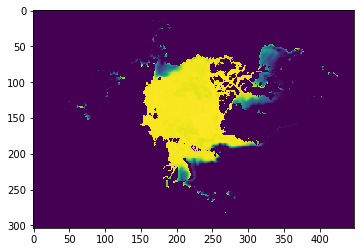

In [109]:
plt.imshow(val_x[0].view(304, 448))

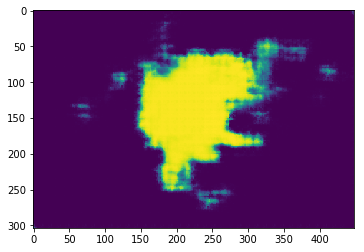

In [110]:
plt.imshow(generated[0].detach().cpu().numpy()[0,:,:])